Mode decomposition of emotional arcs!
----------------------------------------------

This second version uses only the linear algebra version of the SVD.

In [3]:
from os import listdir
from os.path import isfile, join
from json import loads
from re import findall,UNICODE
import sys
sys.path.append("/Users/andyreagan/tools/python")
from kitchentable.dogtoys import *
from labMTsimple.labMTsimple.speedy import LabMT
my_LabMT = LabMT()
from labMTsimple.labMTsimple.storyLab import *
import numpy as np
from database.bookclass import Book_raw_data
import pickle

import os
sys.path.append('/Users/andyreagan/projects/2014/09-books/database')
os.environ.setdefault('DJANGO_SETTINGS_MODULE','gutenbergdb.settings')
import django
django.setup()

from library.models import *

from tqdm import tqdm

In [100]:
# all our essentials
from matplotlib import rc,rcParams
from matplotlib.colors import Colormap
rc('font', family='sans-serif') 
rc('font', serif='Helvetica Neue')
rc('text', usetex='false')

rc('font', family='serif')
rc('font', family='cmr10')
rc('text', usetex='true')
# this should accomplish the same thing
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{hyperref}'
rcParams['text.latex.unicode'] = True

rcParams.update({'font.size': 12})
import matplotlib.pyplot as plt
%matplotlib inline

# import matplotlib
# matplotlib.use("pgf")
# pgf_with_custom_preamble = {
#     "text.usetex": True,
#     "text.latex.unicode": True,
#     "pgf.preamble": [
#         r"\usepackage{hyperref}"
#         ]
# }
# matplotlib.rcParams.update(pgf_with_custom_preamble)
# matplotlib.rcParams.update({'font.size': 12})
# from matplotlib import pyplot as plt

In [5]:
q = Book.objects.filter(exclude=False,length__gt=10000,length__lte=200000,
                        downloads__gte=150,numUniqWords__gt=1000,numUniqWords__lt=18000,lang_code_id=0)
q = Book.objects.filter(exclude=False,length__gt=20000,length__lte=100000,
                        downloads__gte=500,lang_code_id=0,locc_with_P=True)
print(len(q))

136


In [ ]:
bins_time = 7

In [6]:
use_cache = True
version = "P-20K-100K-500-7pt"
if isfile("data/gutenberg/timeseries-matrix-cache-{}.p".format(version)) and use_cache:
    big_matrix = pickle.load(open("data/gutenberg/timeseries-matrix-cache-{}.p".format(version),"rb"))
else:
    # load all of the timeseries into a matrix
    big_matrix = np.ones([len(q),7])
    # big_matrix_mean0 = np.ones(big_matrix.shape)
    stop_val = 1.0
    
    for i in tqdm(range(len(q))):
        b = q[i]
        b_data = Book_raw_data(b)
        a = b_data.chopper_sliding(my_LabMT,num_points=bins_time,stop_val=stop_val,use_cache=True)
        big_matrix[i,:] = b_data.timeseries
    print(big_matrix.shape)
    pickle.dump(big_matrix,open("data/gutenberg/timeseries-matrix-cache-{}.p".format(version),"wb"),pickle.HIGHEST_PROTOCOL)

100%|██████████| 136/136 [00:12<00:00, 10.64it/s]

(136, 7)


In [9]:
assert len(q) == big_matrix.shape[0]

In [142]:
abs_range = [big_matrix.min(),big_matrix.max()]
bins_vert = 7

print(abs_range)

[5.3816316736652672, 6.1718978102189777]


In [143]:
# now let's go replace big_matrix with entries 0-6

In [144]:
coarse_grained = np.zeros(big_matrix.shape)

In [145]:
coarse_grained.shape

(136, 7)

In [146]:
def find_bin_i(bins,x):
    j = 0
    while x >= bins[j] and j<len(bins)-1:
        j+=1
    return j-1
def find_bin_map(bins):
    return lambda x: find_bin_i(bins,x)
# damnit non functional

In [147]:
bins = np.linspace(abs_range[0],abs_range[1],num=bins_vert+1)

In [148]:
bins

array([ 5.38163167,  5.49452684,  5.607422  ,  5.72031716,  5.83321232,
        5.94610749,  6.05900265,  6.17189781])

In [149]:
for i in range(len(q)):
    coarse_grained[i,:] = list(map(lambda x: find_bin_i(bins,x),big_matrix[i,:]))

In [150]:
coarse_grained[:10,:]

array([[ 3.,  3.,  3.,  3.,  4.,  3.,  4.],
       [ 4.,  3.,  3.,  3.,  4.,  3.,  4.],
       [ 4.,  2.,  3.,  3.,  2.,  2.,  4.],
       [ 1.,  3.,  5.,  4.,  4.,  1.,  4.],
       [ 2.,  3.,  6.,  5.,  4.,  2.,  4.],
       [ 6.,  5.,  5.,  6.,  6.,  6.,  5.],
       [ 5.,  4.,  5.,  3.,  4.,  5.,  4.],
       [ 5.,  4.,  4.,  3.,  2.,  3.,  3.],
       [ 3.,  2.,  2.,  1.,  1.,  2.,  3.],
       [ 3.,  2.,  1.,  2.,  2.,  2.,  2.]])

In [151]:
coarse_grained.max()

6.0

In [152]:
coarse_grained.min()

0.0

In [153]:
histofun = np.zeros((bins_vert,bins_time))
print(histofun.shape)

(7, 7)


In [154]:
for i in range(bins_time):
    histofun[:,i] = np.histogram(coarse_grained[:,i],bins=np.arange(bins_vert+1)-.5)[0].transpose()

In [155]:
histofun

array([[  2.,   3.,   3.,   1.,   3.,   5.,   1.],
       [  3.,   5.,  10.,   8.,  10.,  13.,   1.],
       [ 14.,  27.,  20.,  24.,  22.,  27.,  26.],
       [ 41.,  34.,  33.,  39.,  37.,  35.,  38.],
       [ 38.,  42.,  46.,  39.,  41.,  37.,  47.],
       [ 28.,  19.,  18.,  17.,  17.,  15.,  21.],
       [ 10.,   6.,   6.,   8.,   6.,   4.,   2.]])

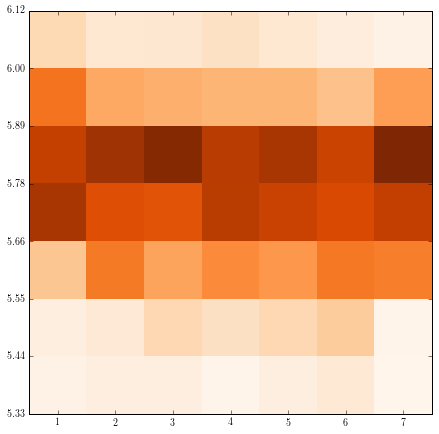

In [160]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([.2,.2,.7,.7])
plt.imshow(histofun,interpolation='none',cmap='Oranges',origin='lower')
ax.set_yticks(np.arange(len(bins))-.5)
ax.set_yticklabels(["{0:.2f}".format(b-(abs_range[1]-abs_range[0])/bins_vert/2) for b in bins])
ax.set_xticks(np.arange(bins_time))
ax.set_xticklabels(np.arange(bins_time)+1)